In [1]:
from pylab import *
from healpy import *
from py_lognormal_mocks import *

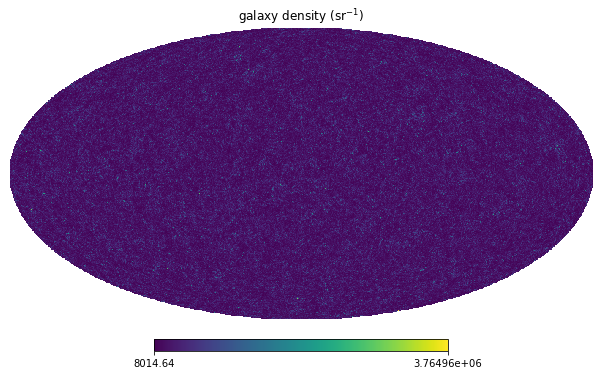

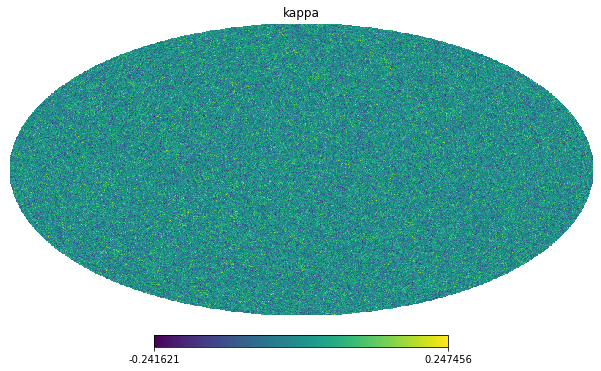

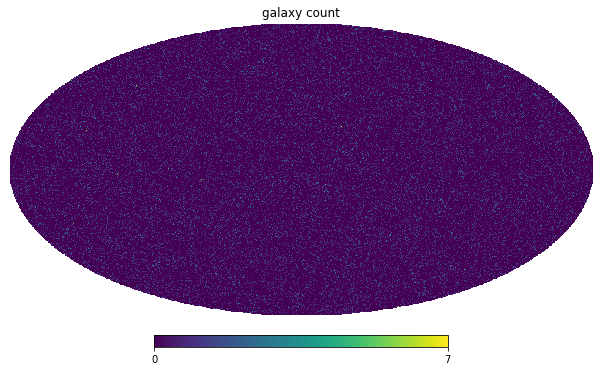

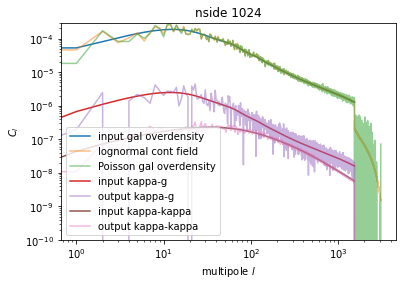

In [2]:
close('all')

seed(329968)
nside = 1024
npix = 12*nside**2
omegapix = 4*pi/npix

clgg = loadtxt("../test/clgg_desregion_z1.txt") # This is the galaxy overdensity power spectrum
clkg = loadtxt("../test/clkg_actregion_z1.txt") # This is the kappa-galaxy overdensity cross
clkk = loadtxt("../test/clkk_th.txt") # This is the kappa-kappa power spectrum

# Truncate each spectrum to the same length
Nl = min([len(clgg),len(clkg), len(clkk)])
clgg = clgg[:Nl]
clkg = clkg[:Nl]
clkk = clkk[:Nl]

ngal = 222828.6428782517 # sr^-1 # mean of galaxy density field
kappabar = 100.0 # a large, fake mean kappa value makes the kappa field more gaussian, it is subtracted away in the end
rhobar = array([ngal,kappabar])  # array of mean must be size Nmap

# Note the ngal factors make the statistics for the galaxy density field
Cl = array([[ ngal**2 * clgg, ngal* clkg ],
            [ ngal* clkg,            clkk]])  # array of input Cl must be size (Nmap, Nmap, Nl).  If this is the wrong shape it will fail 

Ntheta = 10000 # accuracy parameter

gaussbar, Clgauss = lognormal_mocks_stats(rhobar,Cl,Ntheta) # get the stats for the Gaussianized fields

almgauss = synalm( (Clgauss[0,0],Clgauss[1,1],Clgauss[1,0]),
               new=True) # make the correlated, gaussianized alms

rhog_gauss = alm2map(almgauss[0],nside) # synthesize the gaussianize maps
kappa_gauss = alm2map(almgauss[1],nside)

# exponentiate to get the non-gaussian maps
rhog = exp(gaussbar[0] + rhog_gauss) # This is the galaxy density field
kappa = exp(gaussbar[1] + kappa_gauss) - kappabar # This is the mean-zero kappa map

countg = poisson(rhog * omegapix) # This is the sampled galaxy counts for each pixel

deltag = countg/omegapix / ngal - 1   # This is the sampled galaxy overdensity

# evaluate the power spectra of the realized maps
Clrhog = anafast(rhog)
Cldeltag = anafast(deltag) - 1/ngal  # This is the power spectrum of the sampled overdensity field, corrected for shot noise
Clkg = anafast(kappa, deltag)
Clkk = anafast(kappa)

# Visualize the results

mollview(rhog,title=r"galaxy density (sr$^{-1}$)")
mollview(kappa,title=r"kappa")
mollview(countg,title="galaxy count")


figure()
plot(clgg,label='input gal overdensity',color='C0')
plot(Clrhog/ngal**2,label='lognormal cont field',color='C1',alpha=0.5)
plot(Cldeltag,label='Poisson gal overdensity',color='C2',alpha=0.5)

plot(clkg, label="input kappa-g",color='C3')
plot(Clkg, label="output kappa-g",color='C4',alpha=0.5)

plot(clkk, label="input kappa-kappa",color='C5')
plot(Clkk, label="output kappa-kappa",color='C6',alpha=0.5)


loglog()
legend()
ylim(1e-10,3e-4)
ylabel(r"$C_l$")
xlabel(r"multipole $l$")
title("nside %d" % nside)

savefig("clkappag_comparison_nside%d.png" % nside)



show()